### essay writing style and demographics prediction

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import time
from IPython.display import clear_output

/home/anna/anaconda3/envs/conda3_env/lib/python3.6/site-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/anna/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


The following blocks only need to be executed if you haven't already cleaned the essay text and pickled the dataframe.

In [3]:
profiles=pandas.read_csv('profiles.csv')
Nprofiles=len(profiles)                       

In [3]:
profiles.head()

age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                                              essay1  \
0  currently working as an international agent fo...   
1  dedicating everyday to being an unbelievable b...   
2  i make nerdy software for musicians, artists, ...   
3          reading things written by old dead people   
4                         work work work work + play   

                                              essay2  \
0  making people laugh.<br />\nranting about a go...   
1  being silly. having ridiculous amonts of fun w...   
2  improvising in different contexts. alternating...   
3  playing synthesizers and organizing books acco...   
4  creating imagery to look at:<br />\nhttp://bag...   

                                              essay3    ...      \
0  the way i look. i am a six foot half asian, ha...    ...       
1                                                NaN    ...       
2  my large jaw and large glasses are the physica...    ...       
3                  socially awkward but i do my best    ...       
4            i smile a lot and my inquisitive nature    ...       

                          location  \
0  south san francisco, california   
1              oakland, california   
2        san francisco, california   
3             berkeley, california   
4        san francisco, california   

                                      offspring orientation  \
0  doesn&rsquo;t have kids, but might want them    straight   
1  doesn&rsquo;t have kids, but might want them    straight   
2                                           NaN    straight   
3                       doesn&rsquo;t want kids    straight   
4                                           NaN    straight   

                        pets                                  religion sex  \
0  likes dogs and likes cats     agnosticism and very serious about it   m   
1  likes dogs and likes cats  agnosticism but not too serious about it   m   
2                   has cats                                       NaN   m   
3                 likes cats                                       NaN   m   
4  likes dogs and likes cats                                       NaN   m   

                                 sign     smokes  \
0                              gemini  sometimes   
1                              cancer         no   
2  pisces but it doesn&rsquo;t matter         no   
3                              pisces         no   
4                            aquarius         no   

                                              speaks     status  
0                                            english     single  
1  english (fluently), spanish (poorly), french (...     single  
2                               english, french, c++  available  
3                           english, german (poorly)     single  
4                                            english     single  

[5 rows x 31 columns]

Since there are too many columns for `head()` to display the response categories, these are the column names:

In [4]:
profiles.columns.tolist()

['age',
 'body_type',
 'diet',
 'drinks',
 'drugs',
 'education',
 'essay0',
 'essay1',
 'essay2',
 'essay3',
 'essay4',
 'essay5',
 'essay6',
 'essay7',
 'essay8',
 'essay9',
 'ethnicity',
 'height',
 'income',
 'job',
 'last_online',
 'location',
 'offspring',
 'orientation',
 'pets',
 'religion',
 'sex',
 'sign',
 'smokes',
 'speaks',
 'status']

The imported data for the essay prompt answers has a lot of newline and break characters, need to remove these, as well as other common phrases (e.g. 'about me') that will show up as frequently used but aren't really useful for studying the people in this sample.

#### Before cleaning up

In [5]:
profiles['essay0'][0]

"about me:<br />\n<br />\ni would love to think that i was some some kind of intellectual:\neither the dumbest smart guy, or the smartest dumb guy. can't say i\ncan tell the difference. i love to talk about ideas and concepts. i\nforge odd metaphors instead of reciting cliches. like the\nsimularities between a friend of mine's house and an underwater\nsalt mine. my favorite word is salt by the way (weird choice i\nknow). to me most things in life are better as metaphors. i seek to\nmake myself a little better everyday, in some productively lazy\nway. got tired of tying my shoes. considered hiring a five year\nold, but would probably have to tie both of our shoes... decided to\nonly wear leather shoes dress shoes.<br />\n<br />\nabout you:<br />\n<br />\nyou love to have really serious, really deep conversations about\nreally silly stuff. you have to be willing to snap me out of a\nlight hearted rant with a kiss. you don't have to be funny, but you\nhave to be able to make me laugh. you

In [21]:
temp=profiles['essay0'][0].replace("\n", " ")
temp=temp.replace("<br />", "")
temp=temp.replace("about me:", "")
temp=temp.replace("about you:", "")
print(temp)

  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes.    you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and telepathically make me s

#### Take out newlines and breaks from essay answer text for all rows

In [15]:
#make list of column names for essay responses
essays_list=['essay'+repr(i) for i in range(0,10)]

#for each individual's ten essay responses, remove "\n", "<br />", "about me: ", "about you:"
for i in range(Nprofiles):
    for essaycol in essays_list:
        profile=profiles[essaycol][i]
        if isinstance(profile, str)==True:
            profile=profile.replace("\n", " ")
            profile=profile.replace("<br />", "")
            profile=profile.replace("/", " ")
            profile=profile.replace("about me:", "")
            profile=profile.replace("about you:", "")
            profiles[essaycol][i] = profile
    if i%50==0:
        clear_output()
        print(i,'/',Nprofiles)
        
# pickle resulting cleaned profile dataframe 
#picklefile=open('cleaned_profiles.p','wb')
#pickle.dump(profiles, picklefile)
#picklefile.close()

59900 / 59946


In [5]:
profiles=pickle.load(open('cleaned_profiles.p', 'rb'))

In [168]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer


Before and after example of what a tokenized essay (the corpus) looks like before and after stop word removal:

#### Before 

In [18]:
test_essay=profiles['essay0'][0]
words = word_tokenize(test_essay)
print(words)

['i', 'would', 'love', 'to', 'think', 'that', 'i', 'was', 'some', 'some', 'kind', 'of', 'intellectual', ':', 'either', 'the', 'dumbest', 'smart', 'guy', ',', 'or', 'the', 'smartest', 'dumb', 'guy', '.', 'ca', "n't", 'say', 'i', 'can', 'tell', 'the', 'difference', '.', 'i', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', '.', 'i', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', '.', 'like', 'the', 'simularities', 'between', 'a', 'friend', 'of', 'mine', "'s", 'house', 'and', 'an', 'underwater', 'salt', 'mine', '.', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', '(', 'weird', 'choice', 'i', 'know', ')', '.', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', '.', 'i', 'seek', 'to', 'make', 'myself', 'a', 'little', 'better', 'everyday', ',', 'in', 'some', 'productively', 'lazy', 'way', '.', 'got', 'tired', 'of', 'tying', 'my', 'shoes', '.', 'considered', 'hiring', 'a', 'five', 'year', 'old', ',', 'but', 'would', 'pro

#### After

In [115]:
test_essay=profiles['essay0'][0]

# remove stop words, i.e. pronounds, the, a, an, etc.
stopWords = set(stopwords.words('english'))
# remove punctuation, leftover ends of contractions formed with stop words, and possessives
punctuation=['?',':','!', ',' ,'.' ,'(' ,')', '&', '$' ,'/', '...', "'", "n't", "'s", "'m", " 'll "]


words = word_tokenize(test_essay)
wordsFiltered = []
 
for w in words:
    if w not in stopWords and w not in punctuation:
        wordsFiltered.append(w)
 
print(wordsFiltered)

['would', 'love', 'think', 'kind', 'intellectual', 'either', 'dumbest', 'smart', 'guy', 'smartest', 'dumb', 'guy', 'ca', 'say', 'tell', 'difference', 'love', 'talk', 'ideas', 'concepts', 'forge', 'odd', 'metaphors', 'instead', 'reciting', 'cliches', 'like', 'simularities', 'friend', 'mine', 'house', 'underwater', 'salt', 'mine', 'favorite', 'word', 'salt', 'way', 'weird', 'choice', 'know', 'things', 'life', 'better', 'metaphors', 'seek', 'make', 'little', 'better', 'everyday', 'productively', 'lazy', 'way', 'got', 'tired', 'tying', 'shoes', 'considered', 'hiring', 'five', 'year', 'old', 'would', 'probably', 'tie', 'shoes', 'decided', 'wear', 'leather', 'shoes', 'dress', 'shoes', 'love', 'really', 'serious', 'really', 'deep', 'conversations', 'really', 'silly', 'stuff', 'willing', 'snap', 'light', 'hearted', 'rant', 'kiss', 'funny', 'able', 'make', 'laugh', 'able', 'bend', 'spoons', 'mind', 'telepathically', 'make', 'smile', 'still', 'work', 'love', 'life', 'cool', 'letting', 'wind', 'b

In [200]:
# define a function to strip out the fluff from all the essays and rejoin into one long string
# this is probably inefficient but I can't figure out how to get get_transform to take lists of words as the corpus

# if response left blank (NaN), return stop word 'i' just so we don't get stuck with a 'not string' error later on


def remove_and_stem(essay, stopWords, punctuation, stemmer=SnowballStemmer("english") ):
    if isinstance(essay, str)==True:
        words = word_tokenize(essay)
        wordsFiltered = []

        for w in words:
            if w not in stopWords and w not in punctuation:
                stemmed_word=stemmer.stem(w)   # stem words (e.g. eating --> eat)
                wordsFiltered.append(stemmed_word)
        s=" "    
        
        return s.join(wordsFiltered)
    else:
        return('i')



In [201]:
processed_corpus_essay0 = [remove_and_stem(response, stopWords, punctuation) for response in profiles['essay0'][:]]

### Create training and test sets

In [251]:
#split the data into training and testing sets. 
#refactor this in the test train-split

frac_training=0.8

train_set_size = int(frac_training*Nprofiles)
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, Nprofiles)

train_sex_id = sex_id_binary[0:train_set_size]
train_processed_corpus = processed_corpus_essay0[0:train_set_size]

test_sex_id = sex_id_binary[train_set_size:Nprofiles]
test_processed_corpus = processed_corpus_essay0[train_set_size:Nprofiles]



### Create model

In [262]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# parameters for vectorizer 
ANALYZER = "word" # unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode' 
TOKENIZER = None
NGRAM_RANGE = (0,2) # Range for n-grams 
MIN_DF = 0.025 # 0.01 Exclude words that are contained in less that x percent of documents 
MAX_DF = 0.9  # Exclude words that are contained in more than x percent of documents 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # already did this
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),  # removed these already except for NaN standins
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)
                            # could add 'token_pattern' argument to specify what denotes a token 

In [263]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF  -- weighting by discrimination power of words

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

#get the bag-of-words from the vectorizer and
#then use TFIDF to weight the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_processed_corpus  ) 
test_bag_of_words = vectorizer.transform( test_processed_corpus )        # document term count matrix
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 19.35s


#### convert labels: m/f --> 0/1

In [264]:
from sklearn import preprocessing

# relabel m/f labels to 0/1: f=0, m=1
sex=profiles['sex']
le = preprocessing.LabelEncoder() 
le.fit(sex)
sex_id_binary = le.transform(sex)

### Try to predict whether the author is male or female based on word usage (using just the first essay right now)

In [265]:
from sklearn.linear_model import LogisticRegression

# Fit a regularized logistic regression model  
clf = LogisticRegression(penalty='l2')

#fit model to TfIDF training data
mdl = clf.fit(train_tfidf, 
              sex_id_binary[train_idx])

#probability of test set (high=depression, low=suicide_watch)
y_score = mdl.predict_proba( test_tfidf )

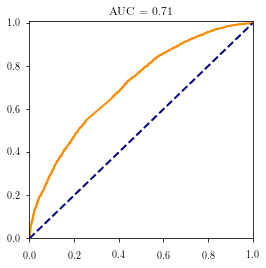

In [290]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
def plot_roc(y_true, y_score):

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score( y_true, y_score)
    
    
    plt.figure(figsize=(4,4))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    #plt.xlabel(r'False Positive Rate')
    #plt.ylabel(r'True Positive Rate')
    auc_str= ("%.2f" % roc_auc)
    plt.title( 'AUC = ' + auc_str) 
    #plt.legend(loc="lower right")
    plt.show()
    
plot_roc(sex_id_binary[train_set_size:], y_score[:,1])

In [289]:
features_stem = vectorizer.get_feature_names()
zipped_coef_features = list( zip(mdl.coef_[0], features_stem),  )
zipped_coef_features.sort()

Ntop_features=15

print('Prompt: Self summary')
print()

print('Top ',repr(Ntop_features),' feature words for female profiles:')

for i in range(0,Ntop_features):
    print(zipped_coef_features[i][1], ',  coef=',zipped_coef_features[i][0])
print()

print('Top ',repr(Ntop_features),' feature words for male profiles:')

for i in range(0,Ntop_features):
    print(zipped_coef_features[len(zipped_coef_features)-i-1][1],',  coef=',zipped_coef_features[len(zipped_coef_features)-i-1][0] )


Prompt: Self summary

Top  15  words for female profiles:
girl ,  coef= -0.286708557938
love ,  coef= -0.201668922411
sweet ,  coef= -0.14611555512
independ ,  coef= -0.131658475384
yoga ,  coef= -0.124728036997
silli ,  coef= -0.116073055485
danc ,  coef= -0.111461983329
laugh ,  coef= -0.101142808914
famili ,  coef= -0.0925821079889
sing ,  coef= -0.089246378307
pleas ,  coef= -0.0764030318831
happi ,  coef= -0.0761706475682
dog ,  coef= -0.075346121443
warm ,  coef= -0.0737860246515
tri new ,  coef= -0.071697073109

Top  15  words for male profiles:
guy ,  coef= 0.360202513142
women ,  coef= 0.13654261414
laid back ,  coef= 0.122209596046
video ,  coef= 0.121957815455
sport ,  coef= 0.0951372592661
born ,  coef= 0.0863369513049
francisco ,  coef= 0.0787602801016
music ,  coef= 0.0773273414368
play ,  coef= 0.0770761392846
href ,  coef= 0.0671906768085
cool ,  coef= 0.0664392879183
work ,  coef= 0.0642245080135
climb ,  coef= 0.0627992048341
joke ,  coef= 0.0614282647431
open mind , 

In [ ]:
words_f = [zipped_coef_features[i][1] for i in range(0,Ntop_features)]
words_m = [zipped_coef_features[len(zipped_coef_features)-i-1][1] for i in range(0,Ntop_features)]

### Clustering with singular value decomposition

[Scipy reference](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py)

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(train_bag_of_words)
V = svd.components_
PC1, PC2, PC3=V[0],V[1],V[2]

In [ ]:
PC1=abs(PC1)
PC2=abs(PC2)
PC3=abs(PC3)
zipped_PCcoef_features = list( zip(PC1, features_stem),  )
sorted_PC_features =  zipped_coef_features.sort()

In [ ]:
for f in range(0,15):
    print(zipped_PCcoef_features[len(zipped_PCcoef_features)-f-1][1],',  coef=',zipped_coef_features[len(zipped_coef_features)-f-1][0] )
    print(zipped_coef_features[f][1], ',  coef=',zipped_coef_features[f][0])